In [310]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sb
import uproot
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr
import sklearn as sk

# Lab 4: Intro to ML

In this lab, we'll use two methods of machine learning: boosted decision trees and neural networks.

### Boosted Decision Tree
Decision trees will take input, and split the data at nodes based on input features of the data. Each node handles a feature of the data, and attempts to split the data in order to mimimize entropy of the output. This is done recursively, and each iteration adjusts the splitting at the nodes, as well as the weight of each node. After each iteration, if a feature of the data is frequently predicted poorly, it will be weighted more because it seems more important than other features. Recursion will continue until some condition is met, such as a number of iterations or an error threshold is met.

### Neural Network
Neural networks use neurons, which are an operation on data that take in multiple features, use them for some computations, and produce one output. The computations can vary in the specifics, but will involve assigning a weight factor to each input feature, and use the sum of these weighted inputs as the argument of a function. The output of this function is the output of the neuron. Several neurons can take in data at the same level, called the layer, and the output of one layer can be input into another layer. These layers are called hidden layers, and on top of the hidden layers there is also the input layer and the output layer. Changing the number of neurons per layer, and the number of hidden layers will affect the success of the network.

In [311]:
# Open all the root files

df_1 = uproot.open('df_1.root')[b'pandas_tree218;1']
df_2 = uproot.open('df_2.root')[b'pandas_tree51358']
df_3 = uproot.open('df_3.root')[b'pandas_tree53278;2']
df_4 = uproot.open('df_4.root')[b'pandas_tree52558;2']
df_5 = uproot.open('df_5.root')[b'pandas_tree53038;2']
df_6 = uproot.open('df_6.root')[b'pandas_tree54718;7']

all_dfs = [df_1, df_2, df_3, df_4, df_5, df_6]

In [312]:
# Get only the parts of the dataframes we want

LLP_data = [0,0,0,0,0,0]
for i in range(6):
    data = all_dfs[i]
    keys = data.keys()[5:]
    df = data.pandas.df(keys)
    data_LLP = df[(df['IsLLP']==True)]
    LLP_data[i] = data_LLP.drop(columns = ['nLLPs_Near_Jets', 'Lz', 'Leta', 'Lphi'])

File df_1 does not have columns 'Lpt' and 'Lpz' so I'll add columns for these in df_1 so later I can remove them along with the other dataframes without problems.

In [313]:
LLP_data[0].insert(1, 'Lpt', np.zeros(len(LLP_data[0])), False)
LLP_data[0].insert(2, 'Lpz', np.zeros(len(LLP_data[0])), False)

In [314]:
# Pull out all detector data into own dataframes

LLP_train = [0,0,0,0,0,0]
LLP_pred = [0,0,0,0,0,0]
for i in range(6):
    data = LLP_data[i]
    x = data.drop(columns = ['IsLLP', 'Lx', 'Ly', 'Lpt', 'Lpz'])
    LLP_train[i] = x.iloc[::2]
    LLP_pred[i] = x.iloc[1::2]

In [315]:
# Pull out all Lxy data into own dataframes

Lxy_train = [0,0,0,0,0,0]
Lxy_pred = [0,0,0,0,0,0]
for i in range(6):
    data = LLP_data[i]
    Lx = data.loc[:,'Lx']
    Ly = data.loc[:,'Ly']
    Lxy = np.sqrt(Lx**2 + Ly**2)
    Lxy_train[i] = Lxy[::2]
    Lxy_pred[i] = Lxy[1::2]

In [316]:
LLP_train_all = pd.concat(LLP_train)
LLP_pred_all = pd.concat(LLP_pred)
Lxy_train_all = pd.concat(Lxy_train)
Lxy_pred_all = pd.concat(Lxy_pred)

Now that the data is organized for training and predicting, I'll first use a boosted decision tree to predict Lxy.

In [317]:
# Create a boosted decision tree regressor to train on our data

regressor = DecisionTreeRegressor()
regressor.fit(LLP_train_all, Lxy_train_all)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

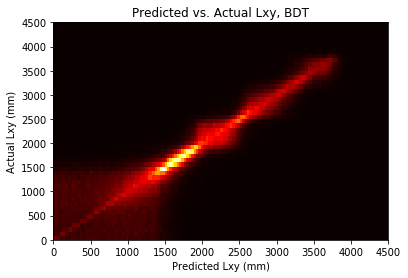

In [318]:
# Plotting the predicted vs. actual Lxy as a 2-D histogram:

X = regressor.predict(LLP_pred_all)
fig = plt.hist2d(X, Lxy_pred_all, bins=(1000, 1000), cmap=plt.cm.hot)
x_range = plt.xlim(0,4500)
y_range = plt.ylim(0,4500)
title = plt.title('Predicted vs. Actual Lxy, BDT')
xlabel = plt.xlabel('Predicted Lxy (mm)')
ylabel = plt.ylabel('Actual Lxy (mm)')

Pearson correlation coefficient between predicted and actual Lxy is 0.7148589017403624


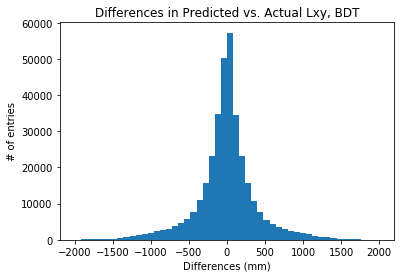

In [319]:
# Plotting a histogram of the differences between actual and predicted Lxy

diff = X - Lxy_pred_all
fig = plt.hist(diff, bins = 50, range = (-2000, 2000))
title = plt.title('Differences in Predicted vs. Actual Lxy, BDT')
xlabel = plt.xlabel('Differences (mm)')
ylabel = plt.ylabel('# of entries')
[a,b] = pearsonr(X, Lxy_pred_all)
print('Pearson correlation coefficient between predicted and actual Lxy is', a)

Now I'll use a neural network to do the same predictions.

In [320]:
mlp = MLPRegressor(hidden_layer_sizes = (10,10,10), max_iter = 500)
mlp.fit(LLP_train_all,Lxy_train_all)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [321]:
# Using the trained neural network to predict our Lxy

pred = mlp.predict(LLP_pred_all)

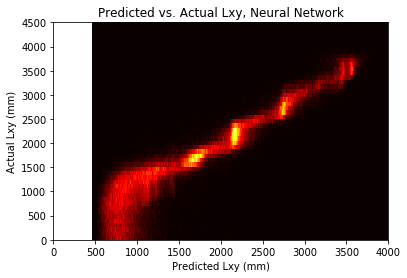

In [322]:
# Plotting the predicted vs. actual Lxy as a 2-D histogram,

fig = plt.hist2d(pred, Lxy_pred_all, bins = (1000,1000), cmap = plt.cm.hot)
x_range = plt.xlim(0,4000)
y_range = plt.ylim(0,4500)
title = plt.title('Predicted vs. Actual Lxy, Neural Network')
xlabel = plt.xlabel('Predicted Lxy (mm)')
ylabel = plt.ylabel('Actual Lxy (mm)')

Pearson correlation between predicted and actual Lxy is 0.8409101127216094


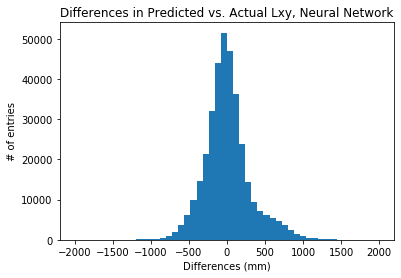

In [323]:
# Plotting the difference between predicted and actual Lxy as a histogram,

diffs = pred - Lxy_pred_all
fig = plt.hist(diffs, bins = 50, range = (-2000,2000))
title = plt.title('Differences in Predicted vs. Actual Lxy, Neural Network')
xlabel = plt.xlabel('Differences (mm)')
ylabel = plt.ylabel('# of entries')
[a,b] = pearsonr(pred, Lxy_pred_all)
print('Pearson correlation between predicted and actual Lxy is', a)

Just in comparing the pearson correlation coefficients, our neural network is noticably better than the boosted decision tree at predicting the decay length of LLP's.

## Now to include some of the non-LLP data to see how our methods of estimating Lxy hold up.

In [324]:
noLLP_data = [0,0,0,0,0,0]
for i in range(6):
    data = all_dfs[i]
    keys = data.keys()[5:]
    df = data.pandas.df(keys)
    data_noLLP = df[(df['IsLLP']==False)]
    noLLP_data[i] = data_noLLP.drop(columns = ['nLLPs_Near_Jets', 'Lz', 'Leta', 'Lphi'])

In [325]:
# File df_1 does not have columns 'Lpt' and 'Lpz' so I'll add columns for these in df_1 so later I can remove them along with the other dataframes

noLLP_data[0].insert(1, 'Lpt', np.zeros(len(noLLP_data[0])), False)
noLLP_data[0].insert(2, 'Lpz', np.zeros(len(noLLP_data[0])), False)

In [326]:
noLLPs = pd.concat(noLLP_data, sort=False)
noLLP = noLLPs.drop(columns = ['IsLLP','Lpt','Lpz','Lx','Ly'])
noLLP.insert(1,'Lx', np.zeros(len(noLLP)))
noLLP.insert(2,'Ly', np.zeros(len(noLLP)))
some_noLLP = noLLP.sample(n=35000)

Now that I've gotten the data for the non-LLP's, I'll choose to incorporate 35,000 of them, which is about 10% of the total LLP data used for predicting.

In [327]:
only_LLP = pd.concat(LLP_data, sort = False)
combined_data = pd.concat([only_LLP, some_noLLP], sort=False)

In [328]:
# To separate out our detector data

x = combined_data.drop(columns = ['IsLLP', 'Lx', 'Ly', 'Lpt', 'Lpz', 'Lx', 'Ly'])
some_LLP_train = x.iloc[::2]
some_LLP_pred = x.iloc[1::2]

In [329]:
# To separate out our Lxy data

Lx = combined_data.loc[:,'Lx']
Ly = combined_data.loc[:,'Ly']
Lxy = np.sqrt(Lx**2 + Ly**2)
some_Lxy_train = Lxy[::2]
some_Lxy_pred = Lxy[1::2]


Now that all the data is prepared for training and predicting, we can start to see how our regressors handle this mixed data.

In [330]:
regressor.fit(some_LLP_train, some_Lxy_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [331]:
X = regressor.predict(some_LLP_pred)

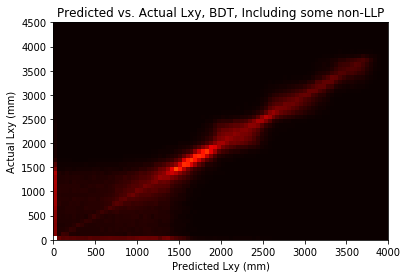

In [332]:
# Plotting the predicted and actual Lxy as a 2-D histogram,

fig = plt.hist2d(X, some_Lxy_pred, bins = (1000,1000), cmap = plt.cm.hot)
x_range = plt.xlim(0,4000)
y_range = plt.ylim(0,4500)
title = plt.title('Predicted vs. Actual Lxy, BDT, Including some non-LLP')
xlabel = plt.xlabel('Predicted Lxy (mm)')
ylabel = plt.ylabel('Actual Lxy (mm)')

Pearson correlation between predicted and actual Lxy is 0.7001714800923838


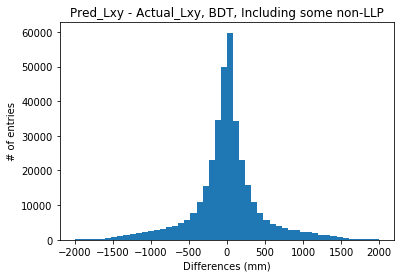

In [333]:
# Predict Lxy from the pred. data using boosted decision tree

diff = X - some_Lxy_pred
fig = plt.hist(diff, bins = 50, range = (-2000, 2000))
title = plt.title('Pred_Lxy - Actual_Lxy, BDT, Including some non-LLP')
xlabel = plt.xlabel('Differences (mm)')
ylabel = plt.ylabel('# of entries')
[a,b] = pearsonr(X, some_Lxy_pred)
print('Pearson correlation between predicted and actual Lxy is', a)

In [334]:
# Train out neural network using the mixed data

mlp.fit(some_LLP_train, some_Lxy_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [335]:
pred_NN = mlp.predict(some_LLP_pred)

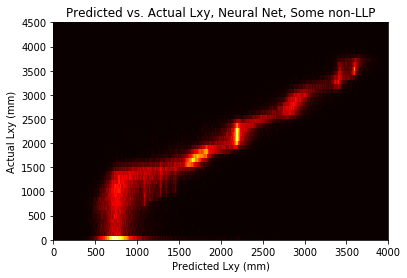

In [336]:
# Plotting predicted vs. actual Lxy as a 2-D histogram,

fig = plt.hist2d(pred_NN, some_Lxy_pred, bins = (1000,1000), cmap = plt.cm.hot)
x_range = plt.xlim(0,4000)
y_range = plt.ylim(0,4500)
title = plt.title('Predicted vs. Actual Lxy, Neural Net, Some non-LLP')
xlabel = plt.xlabel('Predicted Lxy (mm)')
ylabel = plt.ylabel('Actual Lxy (mm)')

Pearson correlation between predicted and actual Lxy is 0.8354412124230141


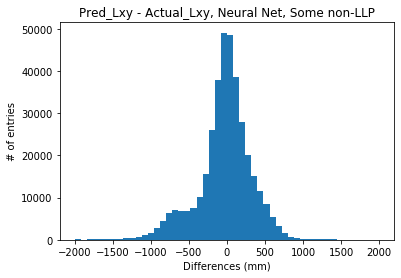

In [338]:
# Plotting a histogram of pred_Lxy - actual_Lxy,

diffs = some_Lxy_pred - pred_NN
fig = plt.hist(diffs, bins = 50, range = (-2000,2000))
title = plt.title('Pred_Lxy - Actual_Lxy, Neural Net, Some non-LLP')
xlabel = plt.xlabel('Differences (mm)')
ylabel = plt.ylabel('# of entries')
[a,b] = pearsonr(pred_NN, some_Lxy_pred)
print('Pearson correlation between predicted and actual Lxy is', a)

Comparing our pearson correlation coefficients from these runs that included some non-LLP data with the initial training on only LLP data, we can see that including some non-LLP data has lowered the accuracy of both the BDT and neural net slightly, but the neural net is still doing noticably better than the BDT. That being said, the BDT only ran for a few 10's of seconds, whereas the neural net took many minutes to train on the full dataset.